# Тестирование планирования траектории с помощью полиномов пятого порядка

Полиномы 5-го порядка являются оптимальной траекторией из состояния $[x_1, \dot{x_1}, \ddot{x_1}]$ в состояние $[x_2, \dot{x_2}, \ddot{x_2}]$, минимизируя функционал стоимости:
$$
J = \int_{t_0}^{t_1}\dddot{x}^2(t)dt
$$

In [162]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.lines as mlines
import sys

### Работа с полиномами пятого порядка (quintic polinoms)
 - Расчет коэффициентов
 - Интерполяция

In [119]:
def calc_quintic(s1, s2, T):
    A = np.array([[   0,       0,       0,      0,    0, 1],
              [   0,       0,       0,      0,    1, 0],
              [   0,       0,       0,      1,    0, 0],
              [   T**5,    T**4,    T**3,   T**2, T, 1],
              [ 5*T**4,  4*T**3,  3*T**2, 2*T,    1, 0], 
              [20*T**3, 12*T**2,  6*T,      1,    0, 0]])
    B = np.array([s1[0], s1[1], s1[2], s2[0], s2[1], s2[2]])
    return np.linalg.solve(A, B)    

def calc_quintic(coefs, x):
    return coefs[0]*x**5 + coefs[1]*x**4 + coefs[2]*x**3 + coefs[3]*x**2 + coefs[4]*x + coefs[5]

def calc_dquintic(coefs, x):
    return 5*coefs[0]*x**4 + 4*coefs[1]*x**3 + 3*coefs[2]*x**2 + 2*coefs[3]*x + coefs[4]

def calc_ddquintic(coefs, x):
    return 20*coefs[0]*x**3 + 12*coefs[1]*x**2 + 6*coefs[2]*x + coefs[3]

def quintic_interpolate(coefs, time):
    n = len(time)
    x = np.zeros(n)
    dx = np.zeros(n)
    ddx = np.zeros(n)

    for i, t in enumerate(time):
        x[i] = calc_quintic(coefs, t)
        dx[i] = calc_dquintic(coefs, t)
        ddx[i] = calc_ddquintic(coefs, t)

    return x, dx, ddx
    
class Trajectory:
    def __init__(self, x, dx, ddx, time):
        
        if len(x) != len(dx) or len(dx) != len(ddx) or len(ddx) != len(time):
            raise ValueError('Arrays should be same length')
        
        self.x = x
        self.dx = dx
        self.ddx = ddx
        self.time = time
        self.valid = None
    
    def len(self):
        return len(self.time)

### Преобразования координат во Frenet Frame (трехгранник Френе)

In [120]:
class FrenetFrame:
    """
    Represents the Frenet Frame
    
    Perform transformation world frame -> local frenet frame
    and local frenet frame -> world frame
    
    Notation:        
        tr  - tangent vector
        nr  - normal vector
        br  - binormal vector (for surface - up)
        Rwf - orientation of local frame with respect to parent frame           
        Rfw - orientation of world frame with respect to parent frame
        Pwf - position of the origin of the local with respect to parent frame
        S0  - covered curve length at the origin of the current frame
    
    Math:
        local->parent transformation:
            Qw = Pwf + Rwf*Qf
            Qa - position in parent frame
            Qb - position in local frame
    
    """
    def __init__(self, s0, p1, p2):
        """
        Create Frenet Frame with two close points on discrete curve.
        Frenet Frame origin will be in point p1
        
        Args:
            s0     - Covered curve length at the point p1.
                     (sum of the length of the all previous segments)
            p1, p2 - Current and next points on the curve.
                     p1p2 is a tangent vector.             
        """
        # local frame axis in parent frame
        self.br = [0, 0, 1]
        self.tr = p2-p1
        self.tr = self.tr/np.linalg.norm(self.tr)
        self.nr = np.cross(self.br, self.tr)[:2]
        
        # local frame orientation with respect to parent frame
        self.Rwf = np.identity(2)
        self.Rwf[:,0]=self.tr
        self.Rwf[:,1]=self.nr
        #self.Rwf[:,2]=self.br
        
        # parent frame orientation with respect to local frame
        self.Rfw = np.transpose(self.Rwf)
        
        # position of the origin of the local with respect to parent frame
        self.Pwf = p1
        
        self.S0 = np.array([s0, 0])
        
    def point_to(self, point):
        """
        Transofrm point in parent frame to the local frame
        """
        return np.matmul(self.Rfw, point - self.Pwf) + self.S0
        
    def point_from(self, point):
        """
        Transofrm point in local frame to the parent frame
        """
        return np.matmul(self.Rwf, point - self.S0)+self.Pwf
    
    def vector_to(self, vector):
        """
        Transform the vector in parent frame to the local frame
        (Position of the frame origin has no effect)
        """
        return np.matmul(self.Rfw, vector)
    
    def vector_from(self, vector):
        """
        Transform the vector in local frame to the parent frame
        (Position of the frame origin has no effect)
        """
        return np.matmul(self.Rwf, vector)

In [128]:
# Создает тестовый путь
def create_path(a1, a2, scale, n):
    p = np.zeros((n, 2))
    i = 0
    for a in np.linspace(math.radians(a1), math.radians(a2), n):
        y = math.sin(a)*scale
        p[i] = [a,y]
        i+=1
        
    return p

# Рисует систему координа
def draw_frame(ax, frame):
    l1 = frame.Pwf
    l2 = frame.Pwf + frame.tr*0.5
    line = mlines.Line2D([l1[0], l2[0]], [l1[1], l2[1]], color='red')
    ax.add_line(line)
    l1 = frame.Pwf
    l2 = frame.Pwf + frame.nr*0.5
    line = mlines.Line2D([l1[0], l2[0]], [l1[1], l2[1]], color='green')
    ax.add_line(line)

In [153]:
def combine_trajectory(trajectory):
    lon_trajectory, lat_trajectory = trajectory
    
    if lat_trajectory.len() != lon_trajectory.len():
        raise ValueError('Lateral and longitudinal trajectories should be same length')
    
    n = lon_trajectory.len()
    
    comb = np.zeros((n, 2))    # combined trajectory   (x)
    dcomb = np.zeros((n, 2))   # combined veclocity    (dx/dt)
    ddcomb = np.zeros((n, 2))  # combined acceleration (d2x/dt^2)
    
    for i in range(n):
        comb[i] = [lon_trajectory.x[i], lat_trajectory.x[i]]
        dcomb[i] = [lon_trajectory.dx[i], lat_trajectory.dx[i]]
        ddcomb[i] = [lon_trajectory.ddx[i], lat_trajectory.ddx[i]]
        
    new_tr =  Trajectory(comb, dcomb, ddcomb, lon_trajectory.time)
    new_tr.valid = lon_trajectory.valid and lat_trajectory.valid
    return new_tr

def path_to_global(local_trajectory, trajectory):
    """
    Convert local path in Frenet Frame to the path in global frame
    
    Args:
        local_trajectory  - local trajectory in Frenet Frame (numpy array)
        trajectory        - original (reference) trajectory. 
                            local path will be "bended" along trajectory
    """
    global_trajectory = np.zeros((len(local_trajectory), 2))
    trajectory_index = 0
    trajectory_s = 0
    trajectory_s_next = np.linalg.norm(trajectory[0] - trajectory[1])
    
    for i, point in enumerate(local_trajectory):
        s = point[0]
        
        while True:            
            if trajectory_s_next >= s:
                break
            
            if trajectory_index >= len(trajectory)-2:
                return global_trajectory[:i]
                
            trajectory_s = trajectory_s_next
            trajectory_s_next += np.linalg.norm(trajectory[trajectory_index+1] - trajectory[trajectory_index])
            trajectory_index += 1
            
        p1 = trajectory[trajectory_index]
        p2 = trajectory[trajectory_index+1]                        
        
        frenet = FrenetFrame(trajectory_s, p1, p2)
        p = frenet.point_from(point)        
        global_trajectory[i] = frenet.point_from(point)
        
    return global_trajectory

### Формирование набора кривых

In [125]:
ROAD_WIDTH = 1.2

T_MIN = 4.0            # Minimum planning time
T_MAX = 8.0            # Maximum planning time
T_STEP = 1             # Planning time variations step

D_MIN = -ROAD_WIDTH/2  # Minimum planning d (road border)
D_MAX = ROAD_WIDTH/2   # Maximum planning d (road border)
D_STEP = 0.2           # Planning d variations step

VELOCITY = 0.5         # Car velocity (constant for now)
MAX_LON_ACC = 1        # Maximum longitudinal acceleration (d2s/dt^2)  
MAX_LAT_ACC = 0.1      # Maximum lateral acceleration (d2d/dt^2)

T_CALC_STEP = 0.2      # Time step for curves interpolation

# Target path (central line)
path = create_path(0, 180, 0.5, 50)

# Initial car position and velocity
car_p = np.array([0, 1])
car_v = np.array([1, 0.4])

# Transform initial car position and velocity to the Frenet Frame
frenet = FrenetFrame(0, path[0], path[1])
car_p_f = frenet.point_to(car_p)  # Car positon in Frenet Frame
car_v_f = frenet.vector_to(car_v) # Car velocity in Frenet Frame

trajectories = []

# Create a set of lateral and longitudal quintic polynoms
for ti in np.arange(T_MIN, T_MAX + T_STEP, T_STEP):
    ts = np.arange(0, ti, T_CALC_STEP)
    
    for di in np.arange(D_MIN, D_MAX + D_STEP, D_STEP):
        # Create lateral motion
        d1 = car_p_f[1]    # lateral position
        dd1 = car_v_f[1]   # lateral speed         
        lat_coefs = quintic_solve((d1, dd1, 0), (di, 0, 0), ti)
        lat_trajectory = Trajectory(*quintic_interpolate(lat_coefs, ts), ts)
            
        # Create longitude motion
        # For now assume constant velocity
        s1 = car_p_f[0]   # longitudinal position
        ds1 = car_v_f[0]  # longitudinal speed
        lon_coefs = [0, 0, 0, 0, VELOCITY, 0]
        lon_trajectory = Trajectory(*quintic_interpolate(lon_coefs, ts), ts)
        
        trajectories.append((lon_trajectory, lat_trajectory))

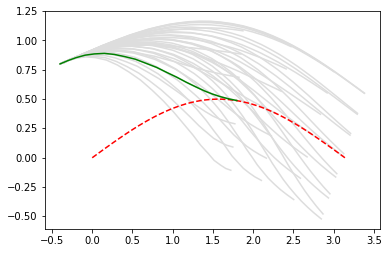

In [187]:
Kj = 1
Kt = 0.5
Kd = 5

def integrate_jerk(trajectory):
    J = 0
    for i in range(trajectory.len()-1):
        a1 = trajectory.ddx[i]
        a2 = trajectory.ddx[i+1]
        t1 = trajectory.time[i]
        t2 = trajectory.time[i+1]
        
        dj = (a2-a1)/(t2-t1)
        J+= dj        
    return J

min_cd = sys.float_info.max
optimal_trajectory = None

for trajectory in trajectories:
    lon, lat = trajectory
    
    lon.valid = all((abs(ddx) <= MAX_LON_ACC for ddx in lon.ddx ))  
    if not lon.valid:
        continue
        
    frenet_trajectory = combine_trajectory(trajectory)
    global_trajectory = path_to_global(frenet_trajectory.x, path)
    plt.plot(global_trajectory[:,0], global_trajectory[:,1], color='#dddddd')
    
    Cd = Kj*integrate_jerk(lat) + Kt*lat.time[-1] + Kd*lat.x[-1]**2
    if Cd < min_cd:
        min_cd = Cd
        optimal_trajectory = global_trajectory
    
    
plt.plot(path[:,0], path[:,1], 'r--')
plt.plot(optimal_trajectory[:,0], optimal_trajectory[:,1], color='g')
plt.show()

### Визуализация поперечных и продольных траекторий
 - Синий - валидные
 - Серый - невалидные (превышено максимальное ускорение)

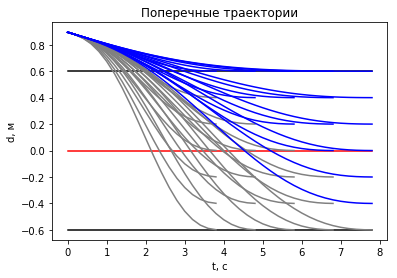

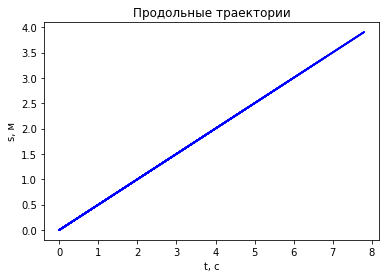

In [136]:
# Borders
ts = np.arange(0, T_MAX, T_CALC_STEP)
plt.plot(ts, [D_MIN]*len(ts), color='k')
plt.plot(ts, [0]*len(ts), color='r')
plt.plot(ts, [D_MAX]*len(ts), color='k')
        
# Valid and invalid lateral trajectories    
for trajectory in trajectories:
    _, lat = trajectory
    lat.valid = all((abs(ddx) <= MAX_LAT_ACC for ddx in lat.ddx ))       
    color = 'blue' if lat.valid else 'grey'    
    plt.plot(lat.time, lat.x, color=color)

plt.xlabel('t, c')
plt.ylabel('d, м')
plt.title('Поперечные траектории')
plt.show()


# Valid and invalid longitudinal trajectories    
for trajectory in trajectories:
    lon, _ = trajectory
    lon.valid = all((abs(ddx) <= MAX_LON_ACC for ddx in lon.ddx ))       
    color = 'blue' if lon.valid else 'grey'    
    plt.plot(lon.time, lon.x, color=color)

plt.xlabel('t, c')
plt.ylabel('s, м')
plt.title('Продольные траектории')
plt.show()
    

### Объединение поперечных и продольных траекторий

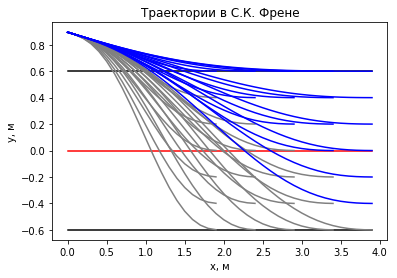

In [152]:
def combine_trajectory(trajectory):
    lon_trajectory, lat_trajectory = trajectory
    
    if lat_trajectory.len() != lon_trajectory.len():
        raise ValueError('Lateral and longitudinal trajectories should be same length')
    
    n = lon_trajectory.len()
    
    comb = np.zeros((n, 2))    # combined trajectory   (x)
    dcomb = np.zeros((n, 2))   # combined veclocity    (dx/dt)
    ddcomb = np.zeros((n, 2))  # combined acceleration (d2x/dt^2)
    
    for i in range(n):
        comb[i] = [lon_trajectory.x[i], lat_trajectory.x[i]]
        dcomb[i] = [lon_trajectory.dx[i], lat_trajectory.dx[i]]
        ddcomb[i] = [lon_trajectory.ddx[i], lat_trajectory.ddx[i]]
        
    new_tr =  Trajectory(comb, dcomb, ddcomb, lon_trajectory.time)
    new_tr.valid = lon_trajectory.valid and lat_trajectory.valid
    return new_tr

frenet_trajectories = []

for trajectory in trajectories:
    frenet_trajectories.append(combine_trajectory(trajectory))    

# Don't worry, just draw road borders
xs = max(frenet_trajectories, key=lambda tr: tr.x[-1, 0]).x[:,0]
plt.plot(xs, [D_MIN]*len(xs), color='k')
plt.plot(xs, [0]*len(xs), color='r')
plt.plot(xs, [D_MAX]*len(xs), color='k')

for trajectory in frenet_trajectories:
    color = 'blue' if trajectory.valid else 'grey'
    plt.plot(trajectory.x[:,0], trajectory.x[:,1], color=color)
    
plt.xlabel('x, м')
plt.ylabel('y, м')
plt.title('Траектории в С.К. Френе')
plt.show()

### Перевод обратно в глобальную систему координат


In [ ]:
"""
        
# Merge lat and lon trajectories
for trajectory in trajectories:
    frenet_trajectories.append(combine_trajectory(trajectory))        
  
n = 100
fp_c = np.zeros((n, 2))
fp_min = np.zeros((n, 2))
fp_max = np.zeros((n, 2))
for i in range(n):
    fp_c[i]=[i*0.1, 0]
    fp_min[i]=[i*0.1, D_MIN]
    fp_max[i]=[i*0.1, D_MAX]
    
plt.plot(fp_c[:,0], fp_c[:,1], color='r')    
plt.plot(fp_min[:,0], fp_min[:,1], color='k')    
plt.plot(fp_max[:,0], fp_max[:,1], color='k')  
    
# Draw trajectories in Frenet Frame
plt.plot(fp_c[:,0], fp_c[:,1], color='r')    
plt.plot(fp_min[:,0], fp_min[:,1], color='k')    
plt.plot(fp_max[:,0], fp_max[:,1], color='k')    

for trajectory in frenet_trajectories:
    plt.plot(trajectory.x[:,0], trajectory.x[:,1])

plt.show()


plt.plot(path[:,0], path[:,1])
#plt.plot(gp_c[:,0], gp_c[:,1])
#plt.plot(gp_min[:,0], gp_min[:,1])
#plt.plot(gp_max[:,0], gp_max[:,1])


for trajectory in frenet_trajectories:
    global_trajectory = path_to_global(trajectory.x, path)
    plt.plot(global_trajectory[:,0], global_trajectory[:,1])

plt.show()
"""

In [147]:
tr.x[-1, 0]

1.9000000000000001